In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import math
import time 

from IPython.display import clear_output
%config IPCompleter.greedy=True

In [2]:
class ES:
    def __init__(
        self,
        eval_f,
        population_size, chromosome_len=20, K=0.9,
        tau0=None, tau1=None,
        n_mutations=1
    ):
        '''
        Args:
            population_size : int
                Number of cars in the population
            chromosome_len : int
                Length of the list, which is our answer for the problem
            K : int
                Kind of learning rate parameter
        '''

        self.eval_f = eval_f
        self.population_size: int = population_size
        self.d: int = chromosome_len
        self.K: float = K
        self.tau0: float = tau0
        self.tau1: float = tau1
        self._best_individual = None
        self._best_cost = -1e8
        self.n_mutations = n_mutations
        
        self.cost_history = []  # List[Tuple[min, mean, max]]
        self.population_history = []  # List[np.ndarray]
        self.sigmas_history = []  # List[np.ndarray]
        self.best_individuals = []  # List[Tuple[np.ndarray, fitness]]
        self.population_std = []

        assert population_size % 2 == 0, 'Population size must be even.'

        if self.tau0 is None:
            self.tau0 = K / np.sqrt(2 * np.sqrt(self.d))

        if self.tau1 is None:
            self.tau1 = K / np.sqrt(2 * self.d)

        self.population_angles = np.random.uniform(
            low=-15,
            high=15,
            size=(self.population_size, self.d)
        )
        # 1 - increase thrust | 0 - nothing | -1 - decrease thrust
        # self.population_thrust = np.random.randint(
        #     low=-1,
        #     high=2,
        #     size=(self.population_size, self.d)
        # )
        n_zeros = self.population_size // 5000
        self.population_thrust1 = np.zeros((self.population_size, n_zeros))
        self.population_thrust2 = np.ones((self.population_size, self.d - n_zeros))
        self.population_thrust = np.hstack((self.population_thrust1, self.population_thrust2))

        self.population = np.stack((self.population_angles, self.population_thrust), axis=2)

        self.sigmas_angles = np.random.uniform(
            low=0,
            high=8,
            size=(self.population_size, self.d)
        )
        self.sigmas_thrust = np.random.uniform(
            low=0,
            high=1,
            size=(self.population_size, self.d)
        )
        self.sigmas = np.stack((self.sigmas_angles, self.sigmas_thrust), axis=2)

        self.cost = self.eval_f(self.population)

    def parents_selection(self) -> np.ndarray:
        """ Roulette method """
        fitness_values = self.cost
        fitness_values = fitness_values - fitness_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(len(self.population)) / len(self.population)

        ids = np.random.choice(
            np.arange(self.population_size),
            size=self.population_size,
            replace=True,
            p=fitness_values
        )
        return ids


    def replacement_and_crossover(self, ids) -> None:
        self.population = self.population[ids]

#         parents_ids = np.arange(self.population_size)
#         np.random.shuffle(parents_ids)

#         p1 = self.population[parents_ids[self.population_size // 2]]
#         p2 = self.population[self.population_size // 2:]

#         r = np.random.rand(self.population_size // 2)[:, np.newaxis, np.newaxis]
#         children1 = r * p1 + (1 - r) * p2
#         children2 = (1 - r) * p1 + r * p2

#         self.population = np.vstack((children1, children2))
#         self.population[:, :, 1] = np.round(self.population[:, :, 1]).astype(np.int)


    def mutation(self) -> None:
        ''' ES algorithm based mutation '''

        E = np.random.normal(0, self.tau1, size=self.sigmas.shape)
        eps_o = np.random.normal(0, self.tau0)
        self.sigmas *= np.exp(E + eps_o)
        self.sigmas = self.sigmas.clip(-15, 15)

        # muatation for angles
        self.population += np.random.normal(0, 1, size=self.sigmas.shape) * self.sigmas
        self.population[:, :, 0] = self.population[:, :, 0].clip(-15, 15)
        self.population[:, :, 1] = self.population[:, :, 1].clip(-1, 1)

        self.population[:, :, 1] = np.round(self.population[:, :, 1]).astype(np.int)
        
        # mutation for power
        # random_indices = np.random.randint(0, self.d, size=(self.n_mutations, self.population_size))
        # self.population[:, :, 1][np.arange(self.population_size), random_indices] = np.random.randint(-1, 2, size=self.population_size)


    def run(self, timeout, start_time) -> None:
        n_iters = 0
        while time.time() - start_time <= timeout:
            best_cost_index = self.cost.argmax()
            best_current_individual = self.population[best_cost_index]
            if self.cost[best_cost_index] > self._best_cost:
                self._best_cost = self.cost[best_cost_index]
                self._best_individual = best_current_individual

            parents_ids = self.parents_selection()
            self.replacement_and_crossover(ids=parents_ids)
            self.mutation()
            self.population[self.cost.argmin()] = best_current_individual  # elitism
            self.cost = self.eval_f(self.population)
            n_iters += 1
            
            self.cost_history.append((self.cost.min(), self.cost.mean(), self.cost.max()))
            self.population_history.append(self.population.copy())
            
            best_indi_id = self.cost.argmax()
            self.sigmas_history.append(self.sigmas[best_indi_id].mean(axis=0))
            self.best_individuals.append((self.population[best_indi_id], self.cost[best_indi_id]))
            self.population_std.append(self.population.std())

        print(f'n_iters: {n_iters}', file=sys.stderr)
        
    
    def plot_cost(self):
        plt.figure(figsize=(15, 5))
        plt.plot(np.array(self.cost_history))
        best_id = np.array(self.cost_history)[:, 2].argmax()
        best_val = np.array(self.cost_history)[:, 2][best_id]
        plt.title(f'POPULATION SIZE: {self.population_size}  |  CHROMOSOME LEN: {self.d}  |  BEST_ITER: {best_id}  |  BEST VAL: {best_val :.3f}')
        plt.legend(['Min', 'Mean', 'Max'], loc='upper right')

    def plot_sigmas(self, mode=''):
        plt.figure(figsize=(15, 5))
        plt.title('Sigmas')
        plt.plot(np.array(self.sigmas_history))
        
    def plot_std(self, mode=''):
        plt.figure(figsize=(15, 5))
        plt.title('Population std')
        plt.plot(np.array(self.population_std))

In [3]:
def create_point_surface(surface) -> dict:
    n = len(surface)
    
    points_surface = {}
    for i in range(n - 1):
        x1, y1 = surface[i]
        x2, y2 = surface[i + 1]
        a = (y1 - y2) / (x1 - x2)
        b = y1 - a * x1
        assert b == y2 - a * x2
        for x in range(x1, x2):
            points_surface[x] = a * x + b
            
    return points_surface

In [4]:
def next_state(
    x: float, y: float, h_speed: float, v_speed: float, fuel: int, angle: int, power: int,
    new_angle: int, new_power: int
):
    GRAVITY = -3.711
    
    assert -1 <= new_power <= 1, f'Wrong new_power: {power}'
    power += new_power
    power = max(0, power)
    power = min(4, power)
    assert power in [0, 1, 2, 3, 4], f'Wrong power: {power}'
    fuel -= power
    
    assert -15 <= new_angle <= 15, f'Wrong new_angle: {new_angle}'
    angle += new_angle
    angle = max(-90, angle)
    angle = min(90, angle)
    assert -90 <= angle <= 90, f'Wrong angle: {angle}'
    
    angle_radians = (angle * math.pi) / 180.0
    a_h = -math.sin(angle_radians) * power
    a_v = math.cos(angle_radians) * power + GRAVITY
    
    x += h_speed + a_h / 2.0
    y += v_speed + a_v / 2.0
    
    h_speed += a_h
    v_speed += a_v
    
    return x, y, h_speed, v_speed, fuel, angle, power

In [5]:
# def ccw(A, B, C) -> bool:
#     return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

# def intersect(A, B) -> bool:
#     """ Return: True if intersect. """
#     for i in range(len(SURFACE) - 1):
#         C = SURFACE[i]
#         D = SURFACE[i + 1]
        
#         if ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D):
#             return True
#     return False


#  Faster intersection
def intersect(point: tuple, point_surface: dict) -> bool:
    """ Return: True if point intersects with surface. """
    x, y = point
    surface_y = point_surface[int(x)]

    return y <= surface_y

In [6]:
def simmulate(
    genotype: np.ndarray,
    x: int, y: int,
    h_speed: int, v_speed: int,
    fuel: int, angle: int, power: int,
    point_surface: list,
    l: int, r: int, h: int
):
    x_start, y_start = x, y
    cords = [(x, y)]

    broke = False
#     print(f'x: {x:.1f}, y: {y:.1f}, speed: {(h_speed, v_speed)}, fuel: {fuel}, angle: {angle}, power: {power}')
    for new_angle, new_power in genotype:
        x2, y2, h_speed2, v_speed2, fuel2, angle2, power2 = next_state(
            x=x, y=y, h_speed=h_speed, v_speed=v_speed, fuel=fuel, angle=angle, power=power,
            new_angle=new_angle, new_power=new_power
        )
        if fuel <= 0 or x2 < 0 or x2 > 6999 or y2 > 2800 or intersect(point=(x2, y2), point_surface=point_surface):
#             print('INTERSECTION')
            broke = True
            break

        x, y, h_speed, v_speed, fuel, angle, power = x2, y2, h_speed2, v_speed2, fuel2, angle2, power2
        cords.append((x, y))
#         print(f'x: {x:.1f}, y: {y:.1f}, speed: {(h_speed, v_speed)}, fuel: {fuel}, angle: {angle}, power: {power}')


    max_dist_x = 0
    max_dist_y = 0
    close_x = 0
    if l <= x <= r:
        close_x = 0
        max_dist_x = 0
    else:
        close_x = min(abs(x - l), abs(x - r)) ** 2
        max_dist_x = min(abs(x_start - l), abs(x_start - r)) ** 2

    close_y = (y - h) ** 2
    max_dist_y = (y_start - h) ** 2

    max_dist = np.sqrt(max_dist_x + max_dist_y)
    act_dist = np.sqrt(close_x + close_y)
    dist_score = (1 - act_dist / max_dist) * 100

    assert -90 <= angle <= 90
    angle_score = (1 - abs(angle) / 90) * 100

    if v_speed <= 40:
        vertical_score = 100
    else:
        broke = True
        vertical_score = -(v_speed - 40)

    if h_speed < 20:
        horizontal_score = 100
    else:
        broke = True
        horizontal_score = -(h_speed - 20)


    score = dist_score * 10 + angle_score + vertical_score + horizontal_score

    if broke or abs(angle) >= 0.49:
        score -= 100000

    return score, cords

In [7]:
def objective_function(
    population: np.ndarray, point_surface: dict, 
    l_start: int, r_start: int, h_start: int,
    x_start: float, y_start: float, 
    h_speed_start: float, v_speed_start: float,
    fuel_start: int, angle_start: float, power_start: int,
):
    costs = []
    for p in population:
        cost = simmulate(
            genotype=p, 
            x=x_start, y=y_start, 
            h_speed=h_speed_start, v_speed=v_speed_start,
            fuel=fuel_start, angle=angle_start, power=power_start,
            point_surface=point_surface,
            l=l_start, r=r_start, h=h_start
        )[0]
        costs.append(cost)
    return np.array(costs)

In [8]:
def find_borders(SURFACE):
    for i in range(len(SURFACE) - 1):
        if SURFACE[i][1] == SURFACE[i + 1][1]:
            return SURFACE[i][0], SURFACE[i + 1][0], SURFACE[i + 1][1]

    return None

In [9]:
SURFACE = np.array([(0, 100), (1000, 500), (1500, 1500), (3000, 1000), (4000, 150), (5500, 150), (6999, 800)])
l_start, r_start, h_start = find_borders(SURFACE)
x_start, y_start = 2500, 2700
h_speed_start, v_speed_start = 0, 0
fuel_start, angle_start, power_start, = 550, 0, 0

In [10]:
# SURFACE = np.array([(0, 100), (1000, 500), (1500, 100), (3000, 100), (3500, 500), (3700, 200), (5000, 1500), (5800, 300), (6000, 1000), (6999, 2000)])
# l_start, r_start = 1500, 3000
# x_start, y_start = 6500, 2800
# h_speed_start, v_speed_start = -100, 0
# fuel_start, angle_start, power_start, = 600, 90, 0

In [11]:
# SURFACE = np.array([(0, 100), (1000, 500), (1500, 1500), (3000, 1000), (4000, 150), (5500, 150), (6999, 800)])
# l_start, r_start = 4000, 5500
# x_start, y_start = 6500, 2800
# h_speed_start, v_speed_start = -90, 0
# fuel_start, angle_start, power_start, = 750, 90, 0

## Creating a surface points

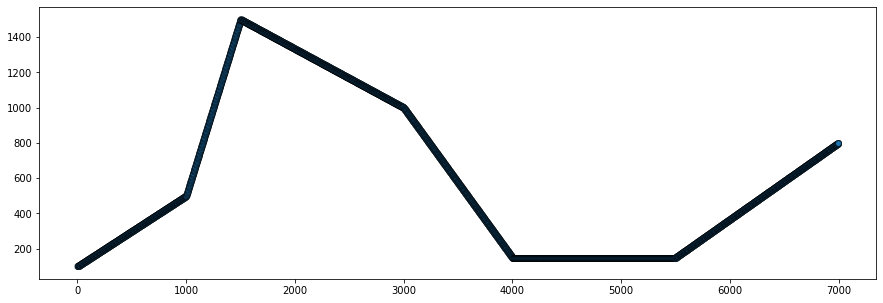

In [12]:
point_surface = create_point_surface(surface=SURFACE)

plt.figure(figsize=(15, 5))
plt.scatter(point_surface.keys(), point_surface.values(), alpha=0.3, edgecolors='black')

## Simulation test

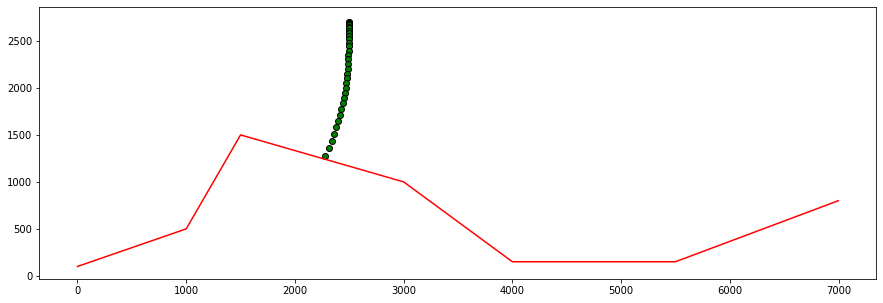

In [13]:
N = 100

tmp = np.vstack((
    np.random.randint(-15, 16, N),
    np.random.randint(-1, 2, N)
)).T

score, cords = simmulate(
    genotype=tmp, 
    x=x_start, y=y_start, 
    h_speed=h_speed_start, v_speed=v_speed_start, 
    fuel=fuel_start, angle=angle_start, power=power_start, 
    point_surface=point_surface,
    l=l_start, r=r_start, h=h_start
)

plt.figure(figsize=(15, 5))
plt.plot(SURFACE[:, 0], SURFACE[:, 1], c='red')

for x, y in cords:
    plt.scatter(x, y, edgecolors='black', color='green')

## Maximum number of simulations

In [14]:
%%time

start_time = time.time()

timeout = 1.0
n_iters = 0
while time.time() - start_time <= timeout:
    N = 100
    tmp = np.vstack((
        np.random.randint(-15, 16, N),
        np.random.randint(-1, 2, N)
    )).T

    score, cords = simmulate(
        genotype=tmp, 
        x=x_start, y=y_start, 
        h_speed=h_speed_start, v_speed=v_speed_start, 
        fuel=fuel_start, angle=angle_start, power=power_start, 
        point_surface=point_surface,
        l=l_start, r=r_start, h=h_start
    )
    n_iters += 1

print(f'Number of iters in {timeout} sec: {n_iters}')

Number of iters in 1.0 sec: 2484
Wall time: 1 s


## ES model

In [15]:
%%time
model = ES(
    eval_f=lambda x: objective_function(
        population=x, point_surface=point_surface,
        l_start=l_start, r_start=r_start, h_start=h_start,
        x_start=x_start, y_start=y_start, 
        h_speed_start=h_speed_start, v_speed_start=v_speed_start,
        fuel_start=fuel_start, angle_start=angle_start, power_start=power_start,
    ), 
    population_size=30, chromosome_len=100, K=2, n_mutations=5
)

Wall time: 14.9 ms


n_iters: 81


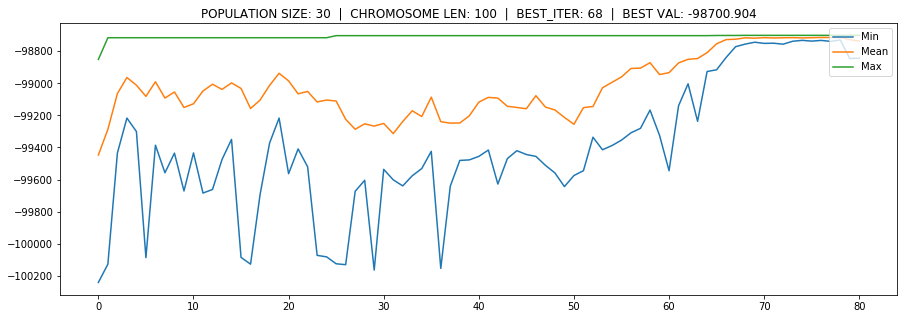

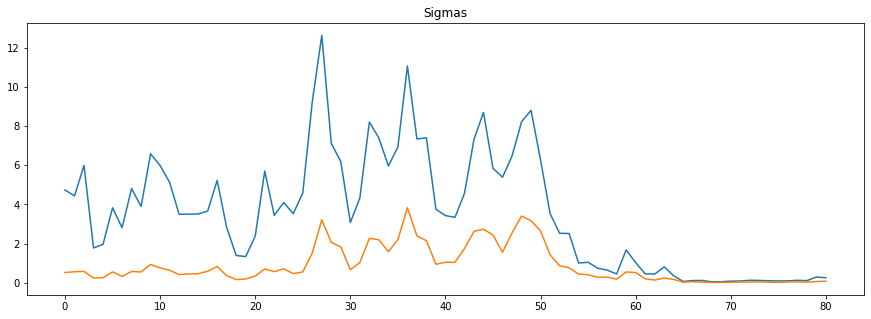

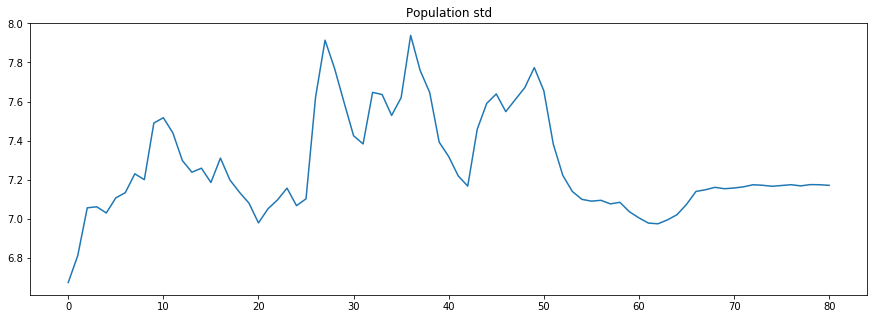

In [16]:
model.run(timeout=0.98, start_time=time.time())
model.plot_cost()
model.plot_sigmas()
model.plot_std()

## End population

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.55it/s]


Wall time: 3.99 s


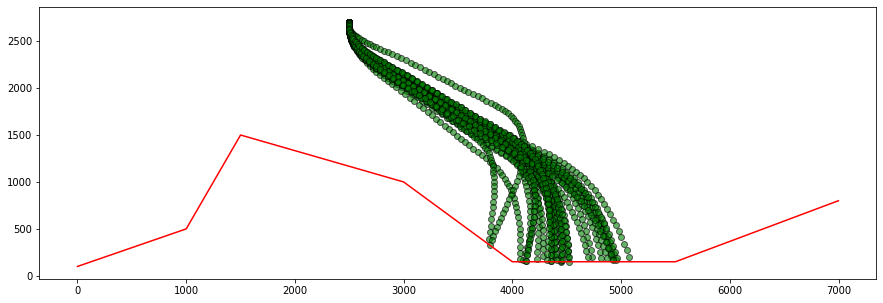

In [17]:
# %%time

# plt.figure(figsize=(15, 5))
# plt.plot(SURFACE[:, 0], SURFACE[:, 1], c='red')

# for genotype in tqdm(model.population, leave=True, position=0):
#     tmp = simmulate(
#         genotype=genotype, 
#         x=x_start, y=y_start, 
#         h_speed=h_speed_start, v_speed=v_speed_start, 
#         fuel=fuel_start, angle=angle_start, power=power_start, 
#         point_surface=point_surface,
#         l=l_start, r=r_start, h=h_start
#     )[1]
#     for x, y in tmp:
#         plt.scatter(x, y, edgecolors='black', color='green', alpha=0.6)

## Best individual

Best cost:  -98700.9042921761


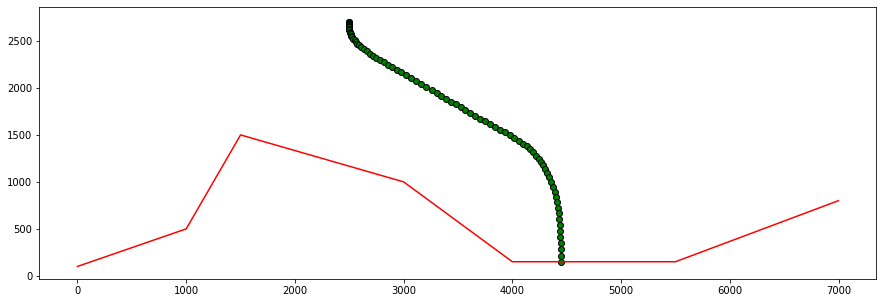

In [18]:
print('Best cost: ', model._best_cost)
score, cords = simmulate(
    genotype=model._best_individual, 
    x=x_start, y=y_start, 
    h_speed=h_speed_start, v_speed=v_speed_start, 
    fuel=fuel_start, angle=angle_start, power=power_start, 
    point_surface=point_surface,
    l=l_start, r=r_start, h=h_start
)

plt.figure(figsize=(15, 5))
plt.plot(SURFACE[:, 0], SURFACE[:, 1], c='red')

for x, y in cords:
    plt.scatter(x, y, edgecolors='black', color='green')

## Visualize evolution

In [19]:
def plot_population(population: np.ndarray):
    plt.figure(figsize=(15, 5))
    for genotype in population:
        plt.plot(SURFACE[:, 0], SURFACE[:, 1], c='red')
        tmp = simmulate(
            genotype=genotype, 
            x=x_start, y=y_start, 
            h_speed=h_speed_start, v_speed=v_speed_start, 
            fuel=fuel_start, angle=angle_start, power=power_start, 
            point_surface=point_surface,
            l=l_start, r=r_start, h=h_start
        )[1]
        for x, y in tmp:
            plt.scatter(x, y, edgecolors='black', color='green', alpha=0.6)
    clear_output(wait=True)
    plt.show()

In [20]:
# %%time

# for i, population in enumerate(model.population_history):
#     print(f'{i + 1} / {len(model.population_history)}')
#     plot_population(population=population)

# RHEA

In [137]:
class Node:
    def __init__(self, action, parent) -> None:
        self._current_action: tuple = action  # pair[int, int]  angle and power
        self._children = {}  # dict[action, Node]
        self._score = -1e18
        self._visited = 0
        self._parent = parent

    def _backpropagate(self, score: float) -> float:
        individual_score = 0
        iters = 0
        while self._parent is not None:
            self._visited += 1
            self._score = max(self._score, score)
            iters += 1
            individual_score += self._score
            self = self._parent

        assert iters > 0, 'ITERS == 0 !!!!!'
        return individual_score / iters

    def rollout(
        self,
        genotype: np.ndarray,
        x: int, y: int,
        h_speed: int, v_speed: int,
        fuel: int, angle: int, power: int,
        point_surface: list,
        l: int, r: int, h: int
    ) -> float:
        x_start, y_start = x, y
        cords = [(x, y)]
        broke = False

        act_node: Node = self
        for new_angle, new_power in genotype:
            x2, y2, h_speed2, v_speed2, fuel2, angle2, power2 = next_state(
                x=x, y=y, h_speed=h_speed, v_speed=v_speed, fuel=fuel, angle=angle, power=power,
                new_angle=new_angle, new_power=new_power
            )
            if fuel <= 0 or x2 < 0 or x2 > 6999 or y2 > 2800 or intersect(point=(x2, y2), point_surface=point_surface):
                broke = True
                break
            x, y, h_speed, v_speed, fuel, angle, power = x2, y2, h_speed2, v_speed2, fuel2, angle2, power2

            if (new_angle, new_power) in self._children:
                act_node = self._children[(new_angle, new_power)]
            else:
                self._children[(new_angle, new_power)] = Node(action=(new_angle, new_power), parent=self)
                act_node = self._children[(new_angle, new_power)]

        max_dist_x, close_x = 0, 0
        if not l <= x <= r:
            close_x = min(abs(x - l), abs(x - r)) ** 2
            max_dist_x = min(abs(x_start - l), abs(x_start - r)) ** 2

        max_dist = np.sqrt(max_dist_x + (y_start - h) ** 2)
        act_dist = np.sqrt(close_x + (y - h) ** 2)
        dist_score = (1 - act_dist / max_dist) * 100

        assert -90 <= angle <= 90
        angle_score = (1 - abs(angle) / 90) * 100

        if v_speed <= 40:
            vertical_score = 100
        else:
            broke = True
            vertical_score = -(v_speed - 40)

        if h_speed < 20:
            horizontal_score = 100
        else:
            broke = True
            horizontal_score = -(h_speed - 20)

        score = dist_score * 2 + angle_score + vertical_score * 5 + horizontal_score
        if broke or abs(angle) >= 0.49 or (y_start - h) > 150:
            score -= 1000000000

        return act_node._backpropagate(score=score)



class RHEA:
    def __init__(self, N, chromosome_len=20, n_mutations=5):
        '''
        Args:
            N : int
                Number of cars in the population
            chromosome_len : int
                Length of the list, which is our answer for the problem
        '''

        self._N: int = N
        self._d: int = chromosome_len
        self.n_mutations: int = n_mutations
        self._best_individual = None
        self._best_cost = -1e18
        self._scores = np.ones(N)
        self.node = Node(action=None, parent=None)
        self.cost_history = []  # List[Tuple[min, mean, max]]
        self.population_std = []
        
        assert N % 2 == 0, 'Population size must be even.'

        self.population_angles = np.random.uniform(
            low=-15,
            high=15,
            size=(self._N, self._d)
        )
        # 1 - increase thrust | 0 - nothing | -1 - decrease thrust
        self.population_thrust = np.random.randint(
            low=1,
            high=2,
            size=(self._N, self._d)
        )
        self.population = np.stack((self.population_angles, self.population_thrust), axis=2)

    def _parents_selection(self) -> np.ndarray:
        """ Roulette method """
        fitness_values = self._scores.copy()
        fitness_values = fitness_values - fitness_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(len(self.population)) / len(self.population)

        ids = np.random.choice(
            np.arange(self._N),
            size=self._N,
            replace=True,
            p=fitness_values
        )
        return ids

    def _replacement_and_crossover(self, ids) -> None:
        self.population = self.population[ids]

        parents_ids = np.arange(self._N)
        np.random.shuffle(parents_ids)

        p1 = self.population[parents_ids[self._N // 2]]
        p2 = self.population[self._N // 2:]

        r = np.random.rand(self._N // 2)[:, np.newaxis, np.newaxis]
        children1 = r * p1 + (1 - r) * p2
        children2 = (1 - r) * p1 + r * p2

        self.population = np.vstack((children1, children2))
        self.population[:, :, 1] = np.round(self.population[:, :, 1]).astype(np.int)

    def _mutation(self) -> None:
        random_indices = np.random.randint(0, self._d, size=(self.n_mutations, self._N))
        
        self.population[:, :, 0][np.arange(self._N), random_indices] = np.random.uniform(-15, 15, size=self._N)
        self.population[:, :, 1][np.arange(self._N), random_indices] = np.random.randint(-1, 2, size=self._N)
        

    def run(self) -> None:
        n_iters = 0
        best_cost_index = self._scores.argmax()
        best_current_individual = self.population[best_cost_index]
        if self._scores[best_cost_index] > self._best_cost:
            self._best_cost = self._scores[best_cost_index]
            self._best_individual = best_current_individual

        parents_ids = self._parents_selection()
        self._replacement_and_crossover(ids=parents_ids)
        self._mutation()
        self.population[self._scores.argmin()] = best_current_individual  # elitism
        
        self.cost_history.append((self._scores.min(), self._scores.mean(), self._scores.max()))
        self.population_std.append(self.population.std())
        
    def population_rollout(
        self,
        x: int, y: int,
        h_speed: int, v_speed: int,
        fuel: int, angle: int, power: int,
        point_surface: list,
        l: int, r: int, h: int
    ):
        scores = []
        for individual in self.population:
            individual_score = self.node.rollout(
                genotype=individual,
                x=x, y=y,
                h_speed=h_speed, v_speed=v_speed,
                fuel=fuel, angle=angle, power=power,
                point_surface=point_surface,
                l=l, r=r, h=h
            )
            scores.append(individual_score)
        self._scores = np.array(scores)
        
    def plot_cost(self):
        plt.figure(figsize=(15, 5))
        plt.plot(np.array(self.cost_history))
        best_id = np.array(self.cost_history)[:, 2].argmax()
        best_val = np.array(self.cost_history)[:, 2][best_id]
        plt.title(f'POPULATION SIZE: {self._N}  |  CHROMOSOME LEN: {self._d}  |  BEST_ITER: {best_id}  |  BEST VAL: {best_val :.3f}')
        plt.legend(['Min', 'Mean', 'Max'], loc='upper right')
        
    def plot_std(self):
        plt.figure(figsize=(15, 5))
        plt.title('Population std')
        plt.plot(np.array(self.population_std))

In [138]:
%%time
CHROMOSOME_LEN = 100
model = RHEA(N=30, chromosome_len=CHROMOSOME_LEN, n_mutations=2)

Wall time: 997 µs


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.59it/s]


Wall time: 23 s


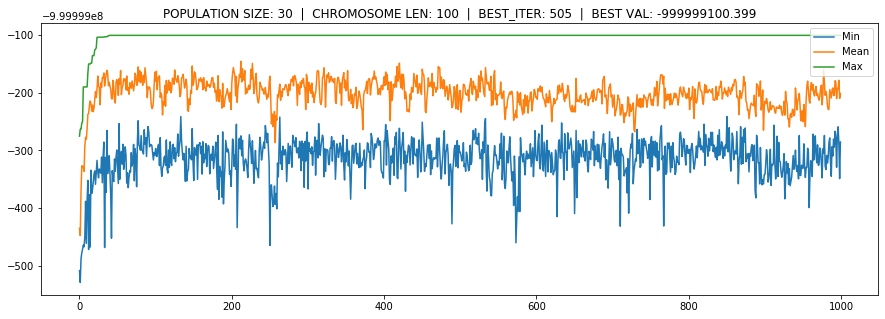

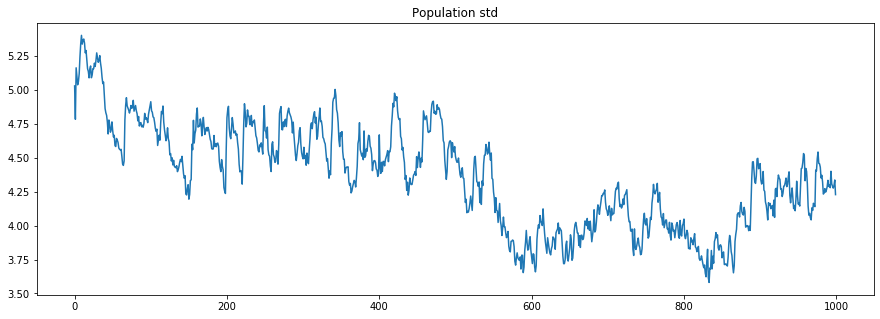

In [139]:
%%time
for _ in tqdm(range(1000), position=0):
    model.population_rollout(
        x=x_start, y=y_start,
        h_speed=h_speed_start, v_speed=v_speed_start,
        fuel=fuel_start, angle=angle_start, power=power_start,
        point_surface=point_surface,
        l=l_start, r=r_start, h=h_start
    )
    model.run()
    
model.plot_cost()
model.plot_std()

Best cost:  -999999100.399119


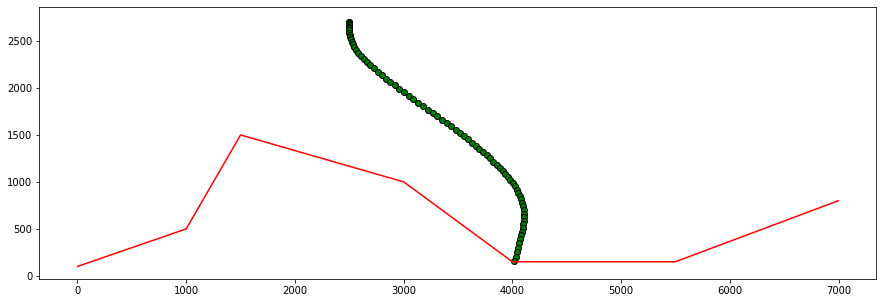

In [140]:
print('Best cost: ', model._best_cost)
score, cords = simmulate(
    genotype=model._best_individual, 
    x=x_start, y=y_start, 
    h_speed=h_speed_start, v_speed=v_speed_start, 
    fuel=fuel_start, angle=angle_start, power=power_start, 
    point_surface=point_surface,
    l=l_start, r=r_start, h=h_start
)

plt.figure(figsize=(15, 5))
plt.plot(SURFACE[:, 0], SURFACE[:, 1], c='red')

for x, y in cords:
    plt.scatter(x, y, edgecolors='black', color='green')

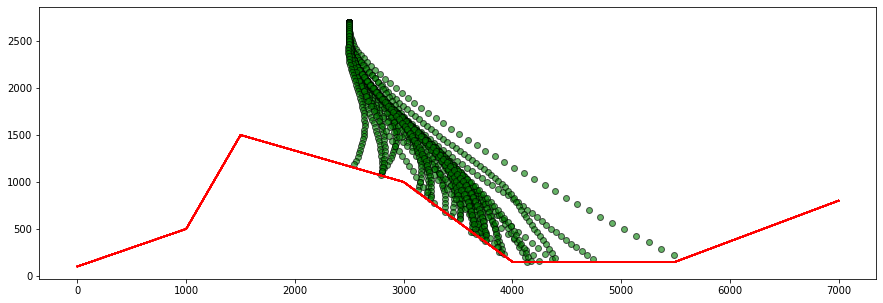

In [141]:
print(model._best_cost)
plot_population(model.population)